In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.auto import tqdm
import optuna

# DATA_PATH = "/content/drive/MyDrive/DACON_DAEGU/data/"
DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/대구 교통사고 피해 예측/data/'
SEED = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [ ]:
import numpy as snp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
# from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer, mean_squared_log_error

# DATA Load

In [ ]:
train_df = pd.read_csv(f"{DATA_PATH}train.csv")
test_df = pd.read_csv(f"{DATA_PATH}test.csv")
accident_df = pd.read_csv(f"{DATA_PATH}countrywide_accident.csv")
DG_cctv = pd.read_csv(f"{DATA_PATH}대구 CCTV 정보.csv", encoding='cp949')
DG_parking = pd.read_csv(f"{DATA_PATH}대구 주차장 정보.csv", encoding='cp949')
DG_children_area = pd.read_csv(f"{DATA_PATH}대구 어린이 보호 구역 정보.csv", encoding='cp949')
DG_seculight = pd.read_csv(f"{DATA_PATH}대구 보안등 정보.csv", encoding='cp949')
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

train_df.shape, test_df.shape, # accident_df.shape, cctv_df.shape, park_df.shape, zone_df.shape, security_df.shape

((39609, 23), (10963, 8))

In [ ]:
# 안개 삭제
train_df.drop(train_df[train_df['기상상태'] == '안개'].index, inplace=True)
accident_df.drop(accident_df[accident_df['기상상태'] == '안개'].index, inplace=True)

# 해빙, nan 삭제
accident_df.drop(accident_df[accident_df['노면상태'] == '해빙'].index, inplace=True)
accident_df.drop(accident_df[accident_df['노면상태'].isnull()].index, inplace=True)

# 철길건널목 삭제
accident_df.drop(accident_df[accident_df['사고유형'] == '철길건널목'].index, inplace=True)

In [ ]:
train_df = pd.concat([train_df, accident_df], axis=0).reset_index().drop(columns='index')

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

# test 데이터 반영
test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

# test 데이터 반영
test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [ ]:
gwangyuk = ['대구광역시','인천광역시','광주광역시','부산광역시','울산광역시','대전광역시']

mask = train_df['도시'].isin(gwangyuk)
train_df = train_df[mask].reset_index().drop(columns='index')

In [ ]:
import holidays
kr_holidays = holidays.KR()
# 시간 관련
train_df['date'] = pd.to_datetime(train_df['사고일시'])
train_df['연'] = train_df['date'].dt.year.astype(int)
train_df['월'] = train_df['date'].dt.month.astype(int)
train_df['일'] = train_df['date'].dt.day.astype(int)
train_df['시간'] = train_df['date'].dt.hour.astype(int)
train_df['요일'] = train_df['date'].dt.day_of_week.astype(int)
train_df['공휴일'] = train_df['date'].apply(lambda x : int(x in kr_holidays)).astype(int)

test_df['date'] = pd.to_datetime(test_df['사고일시'])
test_df['연'] = test_df['date'].dt.year.astype(int)
test_df['월'] = test_df['date'].dt.month.astype(int)
test_df['일'] = test_df['date'].dt.day.astype(int)
test_df['시간'] = test_df['date'].dt.hour.astype(int)
test_df['요일'] = test_df['date'].dt.day_of_week.astype(int)
test_df['공휴일'] = test_df['date'].apply(lambda x : int(x in kr_holidays)).astype(int)

train_df = train_df.drop(columns=['사고일시','date'])
test_df = test_df.drop(columns=['사고일시','date'])

In [ ]:
# train_df['월동_총부상자'] = train_df['사망자수'] + train_df['중상자수'] + train_df['경상자수'] + train_df['부상자수']

# casualty = train_df.groupby(['월','도시','구','동'])[['월동_총부상자']].mean().reset_index()
# train_df = train_df.drop(columns = '월동_총부상자')

# train_df = pd.merge(train_df,casualty, on = ['월','도시','구','동'], how='left')
# test_df = pd.merge(test_df,casualty, on = ['월','도시','구','동'], how='left')


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Columns: 190 entries, ID to 사고유형_차량단독
dtypes: float64(121), int64(9), object(20), uint64(40)
memory usage: 57.7+ MB


In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 90 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   요일                  39609 non-null  object 
 1   기상상태                39609 non-null  object 
 2   노면상태                39609 non-null  object 
 3   사고유형                39609 non-null  object 
 4   연                   39609 non-null  int64  
 5   월                   39609 non-null  int64  
 6   일                   39609 non-null  int64  
 7   시간                  39609 non-null  int64  
 8   구                   39609 non-null  object 
 9   동                   39609 non-null  object 
 10  도로형태1               39609 non-null  object 
 11  도로형태2               39609 non-null  object 
 12  보안등_전용주             30096 non-null  float64
 13  보안등_한전주             30096 non-null  float64
 14  보호구역구분_1.0          38033 non-null  float64
 15  단속구분_1              38033 non-null  float64
 16  단속구분

In [ ]:
from sklearn.preprocessing import LabelEncoder
# from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

['요일', '기상상태', '노면상태', '사고유형', '구', '동', '도로형태1', '도로형태2']

In [ ]:
for col in categorical_features:
    enc = LabelEncoder()
    train_x[col]=enc.fit_transform(train_x[col])
    test_x[col]=enc.transform(test_x[col])

train_x.head()

,요일,기상상태,노면상태,사고유형,연,월,일,시간,구,동,...,기상상태_눈,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_침수,도로형태1_주차장,도로형태2_고가도로위,도로형태2_교량,도로형태2_주차장,도로형태2_터널
0,6,2,0,0,2019,1,1,0,7,40,...,0,0,0,0,0,0,0,0,0,1
1,6,5,0,0,2019,1,1,0,1,4,...,0,1,0,0,0,3,0,0,3,0
2,6,2,0,0,2019,1,1,1,6,66,...,0,0,0,0,0,6,0,0,6,1
3,6,2,0,1,2019,1,1,2,4,79,...,0,0,0,0,0,2,1,8,2,1
4,6,2,0,1,2019,1,1,4,3,129,...,0,2,0,0,0,4,3,5,4,0


In [ ]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

# 학습 및 검증

In [ ]:
target = np.log1p(train_y)
target

0        1.791759
1        1.386294
2        1.386294
3        1.791759
4        1.386294
           ...   
39604    1.386294
39605    1.386294
39606    2.397895
39607    1.386294
39608    1.945910
Name: ECLO, Length: 39609, dtype: float64

In [ ]:
def rmsle(y_valid, pred):
    msle = mean_squared_log_error(y_valid, pred)
    return np.sqrt(msle)

rmsle_score = make_scorer(rmsle, greater_is_better=False)

## DL

In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

# print(train_x.shape, train_y.shape)
# print(train_x.isnull().sum().sum(), train_y.isnull().sum().sum())

In [ ]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

In [ ]:
model = create_model()
history = model.fit(train_x.astype('float32'),target.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
1114/1114 [==============================] - 3s 2ms/step - loss: 0.1930 - metric_fn: 0.1930 - val_loss: 0.1716 - val_metric_fn: 0.1716 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1749 - metric_fn: 0.1749 - val_loss: 0.1695 - val_metric_fn: 0.1695 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1733 - metric_fn: 0.1733 - val_loss: 0.1670 - val_metric_fn: 0.1670 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1719 - metric_fn: 0.1719 - val_loss: 0.1663 - val_metric_fn: 0.1663 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1710 - metric_fn: 0.1710 - val_loss: 0.1650 - val_metric_fn: 0.1649 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1710 - metric_fn: 0.1710 - val_loss: 0.1644 - val_metric_fn: 0.1644 - lr: 0.0010
Epoch 7/100
1114/1114 [=================

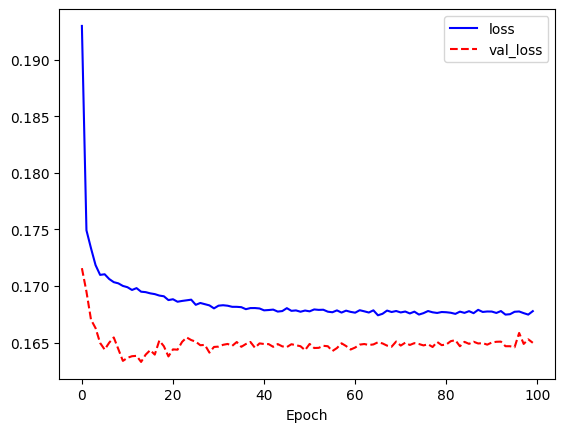

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
dl_predict =  model.predict(test_x.astype('float32'))
dl_predict = np.expm1(dl_predict)

submission['ECLO'] = dl_predict
submission

343/343 [==============================] - 1s 2ms/step


,ID,ECLO
0,ACCIDENT_39609,4.667102
1,ACCIDENT_39610,3.626272
2,ACCIDENT_39611,4.721074
3,ACCIDENT_39612,4.073140
4,ACCIDENT_39613,4.563628
...,...,...
10958,ACCIDENT_50567,3.162949
10959,ACCIDENT_50568,3.740185
10960,ACCIDENT_50569,4.121490
10961,ACCIDENT_50570,4.414340


In [ ]:
submission.to_csv('feature_exp_v2_1125_dl.csv', index=False)
submission.to_csv(f'{DATA_PATH}feature_exp_v2_1125_dl.csv', index=False)

## XGB

In [ ]:
def xgb_objective(trial):
    params = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = XGBRegressor(**params, random_state=SEED)
    scores = cross_val_score(model, train_x, target, cv=cv, scoring=rmsle_score, n_jobs=-1)

    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(xgb_objective, n_trials=100)

[I 2023-11-25 09:19:33,263] A new study created in memory with name: no-name-19329104-a9a0-4577-9db6-cba56bf49750
[I 2023-11-25 09:19:37,671] Trial 0 finished with value: -0.17258338968160764 and parameters: {'n_estimators': 118, 'max_depth': 48, 'learning_rate': 0.07587945476302646, 'gamma': 0.5986584841970366, 'min_child_weight': 2, 'subsample': 0.2403950683025824, 'colsample_bytree': 0.15227525095137953, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: -0.17258338968160764.
[I 2023-11-25 09:19:44,184] Trial 1 finished with value: -0.1719765951995305 and parameters: {'n_estimators': 216, 'max_depth': 3, 'learning_rate': 0.0972918866945795, 'gamma': 0.8324426408004217, 'min_child_weight': 3, 'subsample': 0.26364247048639056, 'colsample_bytree': 0.2650640588680905, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: -0.1719765951995305.
[I 2023-11-25 09:19:48,198] Trial 2 finished with value: -0.171

- -0.1704821289593484 -> -0.17046108602566407

In [ ]:
xgb_params = study.best_params
xgb_params

{'n_estimators': 233,
 'max_depth': 7,
 'learning_rate': 0.09211108160719442,
 'gamma': 0.06268840482685693,
 'min_child_weight': 9,
 'subsample': 0.5235402966805525,
 'colsample_bytree': 0.8952889347269768,
 'reg_alpha': 2.1788779743737687,
 'reg_lambda': 4.575666803087897}

In [ ]:
xgb_model = XGBRegressor(**xgb_params, random_state=SEED)
xgb_model.fit(train_x, target)
xgb_pred = xgb_model.predict(test_x)
xgb_pred = np.expm1(xgb_pred) # log 역 변환
xgb_pred

array([4.212882 , 3.7429473, 5.071863 , ..., 4.817176 , 4.8406463,
       4.037233 ], dtype=float32)

In [ ]:
xgb_sub = submission.copy()
xgb_sub['ECLO'] = xgb_pred
xgb_sub

,ID,ECLO
0,ACCIDENT_39609,4.212882
1,ACCIDENT_39610,3.742947
2,ACCIDENT_39611,5.071863
3,ACCIDENT_39612,4.084635
4,ACCIDENT_39613,4.776392
...,...,...
10958,ACCIDENT_50567,4.944338
10959,ACCIDENT_50568,4.536902
10960,ACCIDENT_50569,4.817176
10961,ACCIDENT_50570,4.840646


In [ ]:
xgb_sub.to_csv(f"{DATA_PATH}feature_exp_v2_1125_xgb.csv", index=False)
xgb_sub.to_csv("feature_exp_v2_1125_xgb.csv", index=False)

## LGBM

In [ ]:
# from sklearn.preprocessing import StandardScaler

# train_lgbm = train_x.copy()
# test_lgbm = test_x.copy()

# # Assuming X is your feature matrix
# scaler = StandardScaler()
# train_lgbm = scaler.fit_transform(train_lgbm)
# test_lgbm = scaler.fit_transform(test_lgbm)


In [ ]:
import re
train_x = train_x.rename(columns = lambda x:re.sub('[^가-힣A-Za-z0-9_]+', '', x))
test_x = test_x.rename(columns = lambda x:re.sub('[^가-힣A-Za-z0-9_]+', '', x))

In [ ]:
def lgbm_objective(trial):
    params = {
        "verbosity": 1,
        'objective': 'regression',
        # 'boosting_type': 'gbdt',
        'eval_metric': 'rmsle',
        'n_estimators': trial.suggest_int('n_estimators', 10, 400),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': -1,
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = LGBMRegressor(**params, random_state=SEED)
    scores = cross_val_score(model, train_x, target, cv=cv, scoring=rmsle_score, n_jobs=-1)

    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(lgbm_objective, n_trials=100)

[I 2023-11-25 11:16:03,559] A new study created in memory with name: no-name-622a8e7b-a917-44ce-88d6-47ff479f2c4e
[I 2023-11-25 11:16:12,499] Trial 0 finished with value: -0.17265720808003976 and parameters: {'n_estimators': 156, 'num_leaves': 244, 'max_depth': 38, 'learning_rate': 0.06026718993550663, 'feature_fraction': 0.24041677639819287, 'bagging_fraction': 0.2403950683025824, 'lambda_l1': 0.5808361216819946, 'lambda_l2': 8.661761457749352, 'min_child_samples': 62}. Best is trial 0 with value: -0.17265720808003976.
[I 2023-11-25 11:16:19,105] Trial 1 finished with value: -0.17097300248226607 and parameters: {'n_estimators': 286, 'num_leaves': 7, 'max_depth': 49, 'learning_rate': 0.08341182143924175, 'feature_fraction': 0.29110519961044856, 'bagging_fraction': 0.26364247048639056, 'lambda_l1': 1.8340450985343382, 'lambda_l2': 3.0424224295953772, 'min_child_samples': 55}. Best is trial 1 with value: -0.17097300248226607.
[I 2023-11-25 11:16:24,872] Trial 2 finished with value: -0.17

- -0.17093993543240787 -> -0.17092023294612774
- lgbm2 : -0.17095695720697088.
- lgbm3 : -0.170918

In [ ]:
lgbm_params = study.best_params
lgbm_params

#trial 1 :
#  {'n_estimators': 287,
#  'depth': 5,
#  'learning_rate': 0.05724317896557044,
#  'l2_leaf_reg': 3.1969295596416476}


{'n_estimators': 173,
 'num_leaves': 22,
 'max_depth': 46,
 'learning_rate': 0.03915590356364884,
 'feature_fraction': 0.4271154527784118,
 'bagging_fraction': 0.7033305622577143,
 'lambda_l1': 7.915214035175035,
 'lambda_l2': 8.003278824790712,
 'min_child_samples': 33}

In [ ]:
lgbm_model = LGBMRegressor(**lgbm_params, random_state=SEED)
lgbm_model.fit(train_x, target)
lgbm_pred = lgbm_model.predict(test_x)
lgbm_pred = np.expm1(lgbm_pred) # log 역 변환
lgbm_pred

[LightGBM] [Warning] feature_fraction is set=0.4271154527784118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271154527784118
[LightGBM] [Warning] lambda_l2 is set=8.003278824790712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.003278824790712
[LightGBM] [Warning] lambda_l1 is set=7.915214035175035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.915214035175035
[LightGBM] [Warning] bagging_fraction is set=0.7033305622577143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7033305622577143
[LightGBM] [Warning] feature_fraction is set=0.4271154527784118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271154527784118
[LightGBM] [Warning] lambda_l2 is set=8.003278824790712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.003278824790712
[LightGBM] [Warning] lambda_l1 is set=7.915214035175035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.915214035175035
[LightGBM] [Warning

array([4.23960842, 3.59866147, 5.23516529, ..., 4.47794908, 4.39132705,
       4.44598765])

In [ ]:
lgbm_sub = submission.copy()
lgbm_sub['ECLO'] = lgbm_pred
lgbm_sub

,ID,ECLO
0,ACCIDENT_39609,4.239608
1,ACCIDENT_39610,3.598661
2,ACCIDENT_39611,5.235165
3,ACCIDENT_39612,4.619211
4,ACCIDENT_39613,4.582958
...,...,...
10958,ACCIDENT_50567,3.998334
10959,ACCIDENT_50568,4.456227
10960,ACCIDENT_50569,4.477949
10961,ACCIDENT_50570,4.391327


In [ ]:
lgbm_sub.to_csv(f"{DATA_PATH}feature_exp_v2_1125_lgbm3.csv", index=False)
lgbm_sub.to_csv("feature_exp_v2_1125_lgbm3.csv", index=False)

## CAT

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [ ]:
# CatBoostRegressor
def cat_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'depth': trial.suggest_int('depth', 1, 16), # 최대 16
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = CatBoostRegressor(**params, random_state=SEED)
    scores = cross_val_score(model, train_x, target, cv=cv, scoring=rmsle_score, n_jobs=-1)

    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(cat_objective, n_trials=100)

[I 2023-11-25 09:58:07,393] A new study created in memory with name: no-name-ca902ba5-e75b-4ad0-920c-0a1bacba9a2c
[I 2023-11-25 10:03:50,536] Trial 0 finished with value: -0.17372185323244796 and parameters: {'n_estimators': 118, 'depth': 16, 'learning_rate': 0.07346740023932911, 'l2_leaf_reg': 5.986584841970366}. Best is trial 0 with value: -0.17372185323244796.
[I 2023-11-25 10:03:52,496] Trial 1 finished with value: -0.17292927231381755 and parameters: {'n_estimators': 55, 'depth': 3, 'learning_rate': 0.006750277604651747, 'l2_leaf_reg': 8.661761457749352}. Best is trial 1 with value: -0.17292927231381755.
[I 2023-11-25 10:04:43,371] Trial 2 finished with value: -0.1724382484117097 and parameters: {'n_estimators': 184, 'depth': 12, 'learning_rate': 0.0030378649352844423, 'l2_leaf_reg': 9.699098521619943}. Best is trial 2 with value: -0.1724382484117097.
[I 2023-11-25 10:04:53,539] Trial 3 finished with value: -0.171301049928643 and parameters: {'n_estimators': 252, 'depth': 4, 'lear

- -0.17103880524768514 -> -0.1709317589252495

In [ ]:
cat_params = study.best_params
cat_params

In [ ]:
cat_model = CatBoostRegressor(**cat_params, random_state=SEED)
cat_model.fit(train_x, target)
cat_pred = cat_model.predict(test_x)
cat_pred = np.expm1(cat_pred) # log 역 변환
cat_pred

0:	learn: 0.4522866	total: 15.1ms	remaining: 4.31s
1:	learn: 0.4517733	total: 47ms	remaining: 6.69s
2:	learn: 0.4512625	total: 66.4ms	remaining: 6.29s
3:	learn: 0.4507652	total: 82ms	remaining: 5.8s
4:	learn: 0.4503676	total: 99.7ms	remaining: 5.62s
5:	learn: 0.4499876	total: 117ms	remaining: 5.5s
6:	learn: 0.4497160	total: 139ms	remaining: 5.58s
7:	learn: 0.4493851	total: 153ms	remaining: 5.33s
8:	learn: 0.4490881	total: 169ms	remaining: 5.23s
9:	learn: 0.4488595	total: 185ms	remaining: 5.13s
10:	learn: 0.4486173	total: 200ms	remaining: 5.03s
11:	learn: 0.4484131	total: 230ms	remaining: 5.28s
12:	learn: 0.4482212	total: 249ms	remaining: 5.24s
13:	learn: 0.4480410	total: 271ms	remaining: 5.29s
14:	learn: 0.4479176	total: 294ms	remaining: 5.33s
15:	learn: 0.4477423	total: 314ms	remaining: 5.32s
16:	learn: 0.4475921	total: 341ms	remaining: 5.41s
17:	learn: 0.4474557	total: 360ms	remaining: 5.38s
18:	learn: 0.4473256	total: 383ms	remaining: 5.4s
19:	learn: 0.4471810	total: 405ms	remaining

array([4.09617317, 3.52124778, 5.09458895, ..., 4.42221416, 4.29598989,
       4.43681507])

In [ ]:
cat_sub = submission.copy()
cat_sub['ECLO'] = cat_pred
cat_sub

,ID,ECLO
0,ACCIDENT_39609,4.096173
1,ACCIDENT_39610,3.521248
2,ACCIDENT_39611,5.094589
3,ACCIDENT_39612,4.516884
4,ACCIDENT_39613,4.674906
...,...,...
10958,ACCIDENT_50567,5.599749
10959,ACCIDENT_50568,4.365638
10960,ACCIDENT_50569,4.422214
10961,ACCIDENT_50570,4.295990


In [ ]:
cat_sub.to_csv(f"{DATA_PATH}feature_exp_v2_1125_cat.csv", index=False)
cat_sub.to_csv("feature_exp_v2_1125_cat.csv", index=False)

# 앙상블

In [ ]:
submission['ECLO']

0        4.667102
1        3.626272
2        4.721074
3        4.073140
4        4.563628
           ...   
10958    3.162949
10959    3.740185
10960    4.121490
10961    4.414340
10962    3.644088
Name: ECLO, Length: 10963, dtype: float32

In [ ]:
submission['ECLO'] = dl_predict

submission['cat'] =cat_sub['ECLO']
submission['lgbm'] =lgbm_sub['ECLO']
submission['xgb'] =xgb_sub['ECLO']

submission['avg_3'] = (cat_sub['ECLO'] + lgbm_sub['ECLO'] + xgb_sub['ECLO'])/3
submission['avg_4'] = (submission['ECLO'] + cat_sub['ECLO'] + lgbm_sub['ECLO'] + xgb_sub['ECLO'])/4
submission['avg_5'] = submission['ECLO']*0.1 + cat_sub['ECLO']*0.3 + lgbm_sub['ECLO']*0.3 + xgb_sub['ECLO']*0.3

submission

,ID,ECLO,cat,lgbm,xgb,avg_3,avg_4,avg_5
0,ACCIDENT_39609,4.667102,4.096173,4.239608,4.212882,4.182888,4.303941,4.231309
1,ACCIDENT_39610,3.626272,3.521248,3.598661,3.742947,3.620952,3.622282,3.621484
2,ACCIDENT_39611,4.721074,5.094589,5.235165,5.071863,5.133872,5.030673,5.092593
3,ACCIDENT_39612,4.073140,4.516884,4.619211,4.084635,4.406910,4.323467,4.373533
4,ACCIDENT_39613,4.563628,4.674906,4.582958,4.776392,4.678085,4.649471,4.666640
...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,3.162949,5.599749,3.998334,4.944338,4.847474,4.426342,4.679021
10959,ACCIDENT_50568,3.740185,4.365638,4.456227,4.536902,4.452922,4.274738,4.381649
10960,ACCIDENT_50569,4.121490,4.422214,4.477949,4.817176,4.572446,4.459707,4.527351
10961,ACCIDENT_50570,4.414340,4.295990,4.391327,4.840646,4.509321,4.485576,4.499823


In [ ]:
submission['avg_5']

0        4.231309
1        3.621484
2        5.092593
3        4.373533
4        4.666640
           ...   
10958    4.679021
10959    4.381649
10960    4.527351
10961    4.499823
10962    4.240420
Name: avg_5, Length: 10963, dtype: float64

In [ ]:
submission_final = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
submission_final

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0
...,...,...
10958,ACCIDENT_50567,0
10959,ACCIDENT_50568,0
10960,ACCIDENT_50569,0
10961,ACCIDENT_50570,0


In [ ]:
submission_final['ECLO'] = submission['avg_5']
submission_final

,ID,ECLO
0,ACCIDENT_39609,4.231309
1,ACCIDENT_39610,3.621484
2,ACCIDENT_39611,5.092593
3,ACCIDENT_39612,4.373533
4,ACCIDENT_39613,4.666640
...,...,...
10958,ACCIDENT_50567,4.679021
10959,ACCIDENT_50568,4.381649
10960,ACCIDENT_50569,4.527351
10961,ACCIDENT_50570,4.499823


In [ ]:
submission_final.to_csv(f"{DATA_PATH}ensemble_avg5_1125.csv", index=False)
submission_final.to_csv("ensemble_avg5_1125.csv", index=False)